In [0]:
import os
from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

import torchvision
import torchvision.datasets as tds
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt

from PIL import Image

import numpy as np

In [0]:
!wget "http://www-sop.inria.fr/members/Alexis.Joly/BelgaLogos/qset3_internal_and_local.gt"
!wget "http://www-sop.inria.fr/members/Alexis.Joly/BelgaLogos/images.tar.gz"
!mv qset3_internal_and_local.gt gt 
!tar -xzf images.tar.gz
images_folder = "images/"
gt_file = "gt"
print('Number of files in the images folder', len(listdir(images_folder)))

--2020-03-19 08:47:28--  http://www-sop.inria.fr/members/Alexis.Joly/BelgaLogos/qset3_internal_and_local.gt
Resolving www-sop.inria.fr (www-sop.inria.fr)... 138.96.0.39
Connecting to www-sop.inria.fr (www-sop.inria.fr)|138.96.0.39|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542926 (530K) [text/plain]
Saving to: ‘qset3_internal_and_local.gt’

qset3_internal_and_ 100%[===================>] 530.20K   143KB/s    in 3.7s    

2020-03-19 08:47:33 (143 KB/s) - ‘qset3_internal_and_local.gt’ saved [542926/542926]

--2020-03-19 08:47:34--  http://www-sop.inria.fr/members/Alexis.Joly/BelgaLogos/images.tar.gz
Resolving www-sop.inria.fr (www-sop.inria.fr)... 138.96.0.39
Connecting to www-sop.inria.fr (www-sop.inria.fr)|138.96.0.39|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1077036878 (1.0G) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>]   1.00G   310KB/s    in 56m 21s 

2020-03-19 09:43:56 (3

In [0]:
device = torch.device("cuda:0")

In [0]:
class LogoDataset(Dataset):
  
  def __init__(self, image_folder, gt, transform=None):
    self.image_folder = image_folder
    self.transform = transform
    self.image_names = {}
    with open(gt) as gt_file:
      gt_content = gt_file.read()
      for image in listdir(image_folder):
        self.image_names[image] = 1 if image in gt_content else 0
    self.keys = list(self.image_names.keys())
  
  def __len__(self):
    return len(self.keys)

  def __getitem__(self, index): 
    image_name = self.keys[index]

    y = self.image_names[image_name]
    image_path = os.path.join(self.image_folder, image_name)

    img = Image.open(image_path).convert('RGB')

    if self.transform:
      img = self.transform(img)

    return img, y, image_path

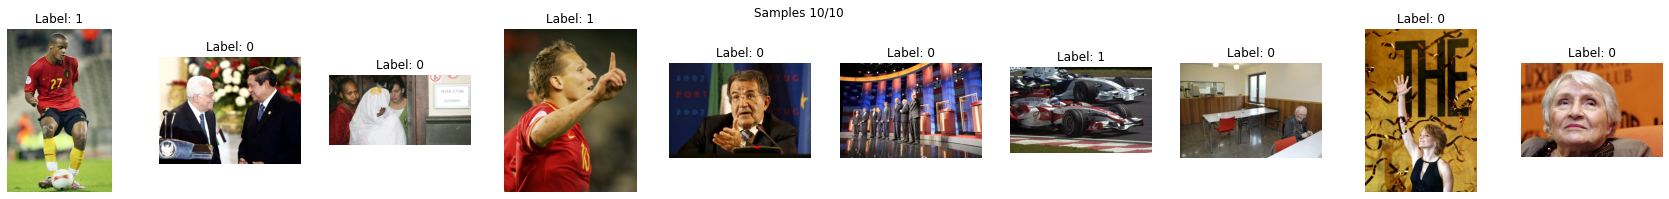

In [0]:
def visualize_samples(dataset, indices, title=None, count=10):
    plt.figure(figsize=(count*3 ,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1, count, i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = LogoDataset(images_folder, gt_file)
indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

In [0]:
tfs = transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomVerticalFlip(p=0.5),
                          transforms.RandomRotation(30),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])                         
                       ])

data_train = LogoDataset(images_folder, gt_file, transform = tfs)

In [0]:
batch_size = 64

validation_size = .3

data_size = len(data_train)
split = int(np.floor(validation_size * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer,  scheduler=None, num_epochs=20):
  train_loss_history = []
  train_history = []
  val_loss_histroy = []
  val_histroy = []

  for i_epoch in range(num_epochs):
    model.train()

    train_loss_sum = 0
    correct_samples = 0
    all_samples = 0

    for i_step, (x, y, _) in enumerate(train_loader):
      x_gpu = x.to(device)
      y_gpu = y.to(device)
      prediction = model(x_gpu)
      step_loss = loss(prediction, y_gpu)
      optimizer.zero_grad()
      step_loss.backward()
      optimizer.step()

      y_hat = torch.argmax(prediction, 1)
      correct_samples += float(torch.sum(y_hat == y_gpu))
      all_samples += y.shape[0]
      train_loss_sum += step_loss
    
    train_loss = train_loss_sum / i_step
    train_accuracy = correct_samples / all_samples
    val_loss, val_accuracy = compute_accuracy(model, val_loader, loss)
    if scheduler:
      scheduler.step(val_loss)

    train_loss_history.append(train_loss)
    val_loss_histroy.append(val_loss)
    train_history.append(train_accuracy)
    val_histroy.append(val_accuracy)

    print('Epoch num: %f, Train loss: %f, Val loss: %f, Train accuracy: %f, Validation accuracy: %f' % (i_epoch, train_loss, val_loss, train_accuracy, val_accuracy))
  
  return train_loss_history, val_loss, train_history, val_histroy

def compute_accuracy(model, loader, loss):
  model.eval()

  correct_samples = 0
  all_samples = 0
  loss_sum = 0

  for i_step, (x, y, _) in enumerate(loader):
    x_gpu = x.to(device)
    y_gpu = y.to(device)

    prediction = model(x_gpu)
    y_hat = torch.argmax(prediction, 1)

    loss_val = loss(prediction, y_gpu)
    loss_sum += float(loss_val)

    correct_samples += float(torch.sum(y_hat == y_gpu))
    all_samples += y.shape[0]
    
  avg_loss = loss_sum / i_step
  accuracy = correct_samples / all_samples

  return avg_loss, accuracy

In [0]:
model = models.resnet50(pretrained=True)
      
for param in model.parameters():
  param.requires_grad = False
        
old_fc = model.fc
model.fc = nn.Linear(old_fc.in_features, 2)
      
model.type(torch.cuda.FloatTensor)
model.to(device)
      
parameters = model.fc.parameters()
      
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(parameters, lr=0.001, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

In [0]:
train_loss_history, val_loss, train_history, val_histroy = train_model(model, train_loader, val_loader, loss, optimizer, scheduler, 10)

In [0]:
def evaluate_model(model, loader):
  predictions = []
  gt = []
  for (x, y, _) in loader:
    x_gpu = x.to(device)
    y_gpu = y.to(device)

    prediction = model(x_gpu)
    y_hat = torch.argmax(prediction, 1)
    
    predictions.append(int(y_hat))
    gt.append(int(y))

  return np.asarray(predictions), np.asarray(gt)

In [0]:
def binary_classification_metrics(prediction, ground_truth):
    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1, accuracy

In [0]:
test_loader = torch.utils.data.DataLoader(data_train, sampler=val_sampler)
epoch_number = 3

learning_rates = [1e-1, 1e-2, 1e-3]
weight_decay = [1e-2, 1e-3, 1e-4]
schedulers = [(0.5, 2), (0.3, 3), (0.5, 5), (0.1, 2)]

for lr in learning_rates:
  for wd in weight_decay:
    for schdlr in schedulers:
      model = models.resnet50(pretrained=True)
      
      for param in model.parameters():
        param.requires_grad = False
        
      old_fc = model.fc
      model.fc = nn.Linear(old_fc.in_features, 2)
      
      model.type(torch.cuda.FloatTensor)
      model.to(device)
      
      parameters = model.fc.parameters()
      
      loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
      optimizer = optim.Adam(parameters, lr=lr, weight_decay=wd)
      scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=schdlr[0], patience=schdlr[1])

      train_loss_history, val_loss, train_history, val_histroy = train_model(model, train_loader, val_loader, loss, optimizer, scheduler, epoch_number)

      prediction, gt = evaluate_model(model, test_loader)
      precision, recall, f1, accuracy = binary_classification_metrics(prediction, gt)
      print('Learning rate: %f, Weight decay: %f, Factor: %f, Patience: %f' % (lr, wd, schdlr[0], schdlr[1]))
      print('Precision: %f, Recall: %f, F1: %f, Accuracy: %f' % (precision, recall, f1, accuracy))

Epoch num: 0.000000, Train loss: 9.297651, Val loss: 2.563177, Train accuracy: 0.732333, Validation accuracy: 0.811714
Epoch num: 1.000000, Train loss: 2.405238, Val loss: 1.139847, Train accuracy: 0.788667, Validation accuracy: 0.828571
Epoch num: 2.000000, Train loss: 2.473605, Val loss: 1.284899, Train accuracy: 0.773333, Validation accuracy: 0.827429
Learning rate: 0.100000, Weight decay: 0.010000, Factor: 0.500000, Patience: 2.000000
Precision: 0.717101, Recall: 0.543177, F1: 0.618138, Accuracy: 0.820143
Epoch num: 0.000000, Train loss: 9.845231, Val loss: 1.831304, Train accuracy: 0.745000, Validation accuracy: 0.839143
Epoch num: 1.000000, Train loss: 2.820707, Val loss: 4.263997, Train accuracy: 0.763000, Validation accuracy: 0.762143
Epoch num: 2.000000, Train loss: 3.048011, Val loss: 3.346033, Train accuracy: 0.784667, Validation accuracy: 0.716143
Learning rate: 0.100000, Weight decay: 0.010000, Factor: 0.300000, Patience: 3.000000
Precision: 0.482721, Recall: 0.938166, F1: